# Baseline Email Assistant

Let's create an Email Assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Drafts responses
- Schedules meetings

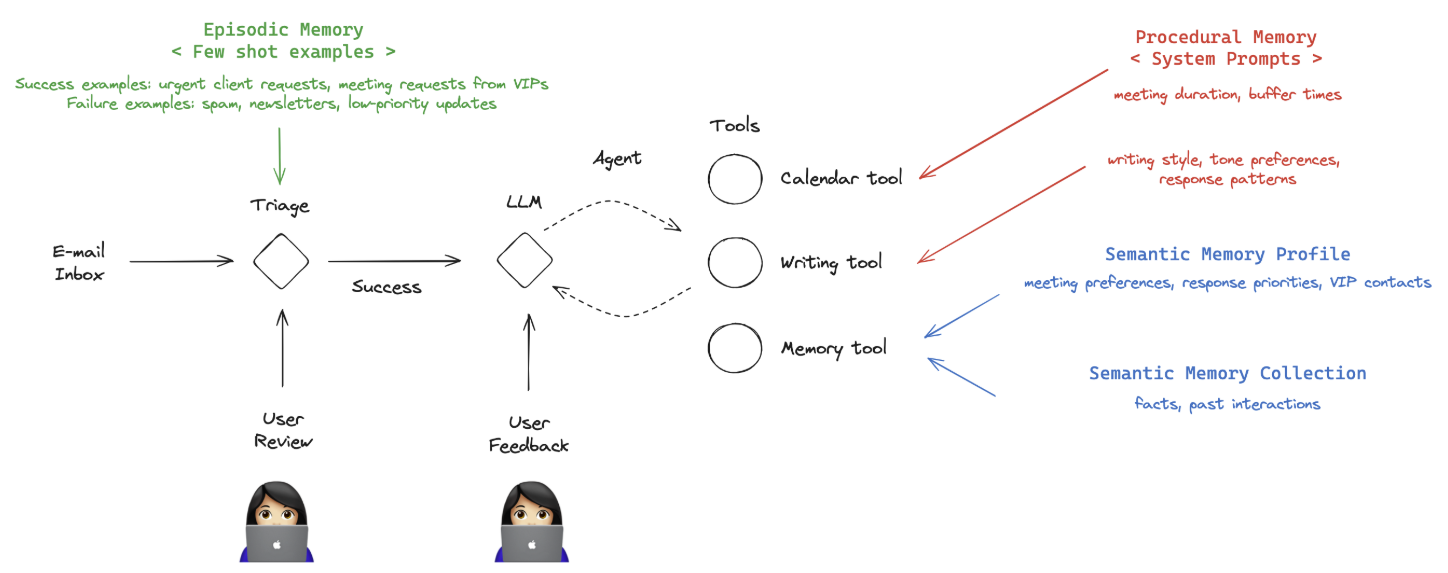


### Load Environment Variables

In [1]:
import os

from dotenv import load_dotenv
load_dotenv()

True

### Create examples for Profile, Prompt and Email

In [2]:
profile = {
    "name": "Sushant",
    "full_name": "Sushant Dhumak",
    "user_profile_background": "Software Development Manager leading a team of 10 developers"
}

In [3]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage Sushant's tasks efficiently."
}

In [4]:
# Example incoming email
email = {
    "from": "John Smith <john.smith@company.com>",
    "to": "Sushant Dhumak <sushant.dhumak@company.com>",
    "subject": "Quick question about API documentation",
    "body": """

    Hi Sushant,

    I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

    Specifically, I'm looking at:
    - /auth/refresh
    - /auth/validate

    Thanks!
    John
    """,
}

### Create Agent -Triage

In [5]:
from pydantic import  BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [6]:
llm = init_chat_model(model="gpt-4o-mini")

In [7]:
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

In [8]:
llm_router = llm.with_structured_output(Router)

In [9]:
# Import from local prompt.py file

from prompts import triage_system_prompt, triage_user_prompt

In [10]:
print(triage_system_prompt)
print("-" * 50)
print(triage_user_prompt)


< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Background >
{user_profile_background}. 
</ Background >

< Instructions >

{name} gets lots of emails. Your job is to categorize each email into one of three categories:

1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that {name} should know about but doesn't require a response
3. RESPOND - Emails that need a direct response from {name}

Classify the below email into one of these categories.

</ Instructions >

< Rules >
Emails that are not worth responding to:
{triage_no}

There are also other things that {name} should know about, but don't require an email response. For these, you should notify {name} (using the `notify` response). Examples of this include:
{triage_notify}

Emails that are worth responding to:
{triage_email}
</ Rules >

< Few shot examples >
{examples}
</ Fe

In [11]:
system_prompt = triage_system_prompt.format(
    full_name = profile["full_name"],
    name = profile["name"],
    user_profile_background = profile["user_profile_background"],
    triage_no = prompt_instructions["triage_rules"]["ignore"],
    triage_notify = prompt_instructions["triage_rules"]["notify"],
    triage_email = prompt_instructions["triage_rules"]["respond"],
    examples = None
)

In [12]:
user_prompt = triage_user_prompt.format(
    author = email["from"],
    to = email["to"],
    subject = email["subject"],
    email_thread = email["body"]
)

In [13]:
result = llm_router.invoke(
    [
        {"role": "system", "content" : system_prompt},
        {"role": "user", "content" : user_prompt},
    ]
)

In [14]:
print(result)

reasoning="This email contains a direct question from a team member (John Smith) regarding the API documentation for the authentication service. Since it is a request for clarification that requires Sushant's input, it necessitates a direct response from Sushant." classification='respond'


### Define tools for Agent

In [15]:
from langchain_core.tools import tool

In [16]:
# Tool to write and send email

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""

    # Email content placeholder to be implemented here

    return f"Email sent to {to} with subject '{subject}'"

In [17]:
# Tool for scheduling meeting

@tool
def schedule_meeting(
    attendees: list[str],
    subject: str,
    duration_minutes: int,
    preferred_day: str
) -> str:
    """Schedule a Meeting"""

    # Calender check and meeting scheduleing placeholder code to be implment here

    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"

In [18]:
# Tool to check Calender for availability

@tool
def check_calender_availability(day: str) -> str:
    """Check calender availability for the given day."""

    # Code to check the calander availability to be implmented here

    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

### Define prompt for Agent

In [19]:
# Import from local prompt.py file

from prompts import agent_system_prompt

In [20]:
print(agent_system_prompt)


< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
</ Tools >

< Instructions >
{instructions}
</ Instructions >



In [21]:
def create_prompt(state):
    return [
        {
            "role": "system",
            "content": agent_system_prompt.format(
                instructions = prompt_instructions["agent_instructions"],
                **profile
            )
        }
    ] + state["messages"]

### Define an Agent

In [22]:
from langgraph.prebuilt import create_react_agent

In [23]:
tools= [write_email, schedule_meeting, check_calender_availability]

In [24]:
agent = create_react_agent(
    model="gpt-4o-mini",
    tools=tools,
    prompt=create_prompt,    
)

In [25]:
response = agent.invoke(
    {
        "messages" : [
            {
                "role": "user",
                "content": "What is my availability for Tuesday?"
            }
        ]
    }    
)

In [26]:
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your availability for Tuesday is as follows:
- 9:00 AM
- 2:00 PM
- 4:00 PM


### Create an Overall Agent

In [27]:
# Define State

from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [28]:
# Graph Imports

from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import display, Image

In [29]:
# Triage Node function

def triage_router(state: State) -> Command[Literal["response_agent", "__end__"]]:

    author = state["email_input"]["author"]
    to = state["email_input"]["to"],
    subject = state["email_input"]["subject"],
    email_thread = state["email_input"]["body"]

    system_prompt = triage_system_prompt.format(
        full_name = profile["full_name"],
        name = profile["name"],
        user_profile_background = profile["user_profile_background"],
        triage_no = prompt_instructions["triage_rules"]["ignore"],
        triage_notify = prompt_instructions["triage_rules"]["notify"],
        triage_email = prompt_instructions["triage_rules"]["respond"],
        examples = None
    )

    user_prompt = triage_user_prompt.format(
        author = author,
        to = to,
        subject = subject,
        email_thread = email_thread
    )

    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    
    return Command(goto=goto, update=update)

In [30]:
# Define the Graph

builder = StateGraph(State)

builder.add_node("triage_router", triage_router)
builder.add_node("response_agent", agent)

builder.add_edge(START, "triage_router")

email_agent = builder.compile()

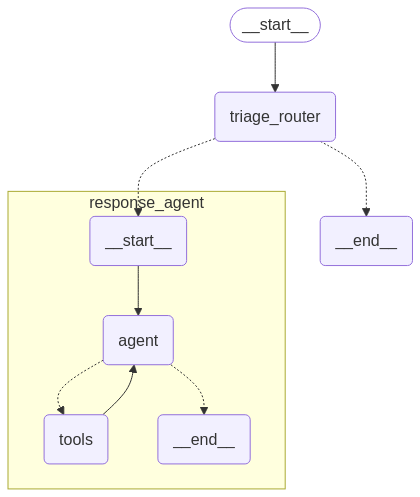

In [31]:
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [32]:
email_input = {

    "author": "Marketing Team <marketing@amazingdeals.com>",
    "to": "Sushant Dhumak <sushant.dhumak@company.com>",
    "subject": "🔥 EXCLUSIVE OFFER: Limited Time Discount on Developer Tools! 🔥",
    "body": """Dear Valued Developer,

    Don't miss out on this INCREDIBLE opportunity! 

    🚀 For a LIMITED TIME ONLY, get 80% OFF on our Premium Developer Suite! 

    ✨ FEATURES:
    - Revolutionary AI-powered code completion
    - Cloud-based development environment
    - 24/7 customer support
    - And much more!

    💰 Regular Price: $999/month
    🎉 YOUR SPECIAL PRICE: Just $199/month!

    🕒 Hurry! This offer expires in:
    24 HOURS ONLY!

    Click here to claim your discount: https://amazingdeals.com/special-offer

    Best regards,
    Marketing Team
    ---
    To unsubscribe, click here
    """,
}

In [33]:
response = email_agent.invoke(
    {"email_input": email_input}
)

🚫 Classification: IGNORE - This email can be safely ignored


In [34]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "Sushant Dhumak <sushant.dhumak@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
    
    Hi Sushant,

    I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

    Specifically, I'm looking at:
    - /auth/refresh
    - /auth/validate

    Thanks!
    Alice
    """,
}

In [35]:
response = email_agent.invoke(
    {"email_input": email_input}
)

📧 Classification: RESPOND - This email requires a response


In [36]:
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Sushant Dhumak <sushant.dhumak@company.com>', 'subject': 'Quick question about API documentation', 'body': "\n    \n    Hi Sushant,\n\n    I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\n    Specifically, I'm looking at:\n    - /auth/refresh\n    - /auth/validate\n\n    Thanks!\n    Alice\n    "}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_Ild99r80AayWlp9DQzR1clLJ)
 Call ID: call_Ild99r80AayWlp9DQzR1clLJ
  Args:
    to: Alice Smith <alice.smith@company.com>
    subject: Re: Quick question about API documentation
    content: Hi Alice,

Thank you for bringing this to my attention. I will look